In [68]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os
from tqdm import tqdm

In [69]:
# ignore warning
import warnings
warnings.filterwarnings("ignore")

### Read data

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = []
    for label in ['NORMAL', 'PNEUMONIA']:
        path = os.path.join(data_dir, label)
        class_num = 1 if label == 'PNEUMONIA' else 0
        for img in tqdm(os.listdir(path)[:1000]):
            try:
                if not img.endswith('.DS_Store'): # Skip non-image files
                    img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                    resized_arr = cv2.resize(img_arr, (150, 150)) # Resize image to (150, 150)
                    data.append([resized_arr, class_num])
            except Exception as e:
                print(f"Error processing {os.path.join(path, img)}: {str(e)}")
    return np.array(data, dtype=object) # Specify dtype as object



In [72]:
train = get_training_data('/content/drive/MyDrive/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/chest_xray/val')

100%|██████████| 8/8 [00:00<00:00, 93.20it/s]


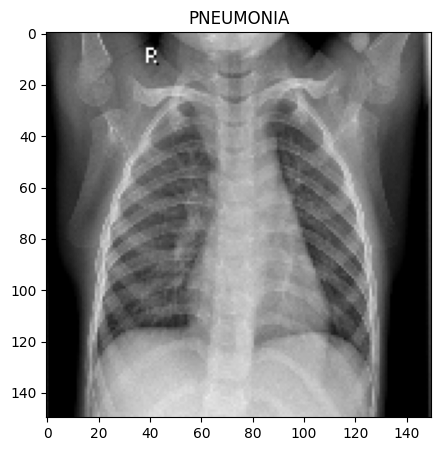

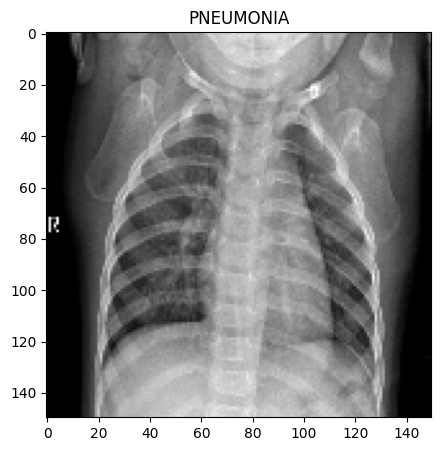

In [73]:
# Pneumonia Sample
plt.figure(figsize = (5,5))
plt.imshow(train[2][0], cmap='gray')
plt.title(labels[train[2][1]])

# Normal Sample
plt.figure(figsize = (5,5))
plt.imshow(train[201][0], cmap='gray')
plt.title(labels[train[201][1]])
plt.show()

In [74]:
# Train
x_train = []
y_train = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)


# Validaiton
x_val = []
y_val = []

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


# Test
x_test = []
y_test = []

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)



In [75]:
# Normalize the data
x_train = (np.array(x_train) / 255)
x_val = (np.array(x_val) / 255)
x_test = (np.array(x_test) / 255)

In [76]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size , 1 )

In [77]:
x_train.shape

(2000, 150, 150, 1)

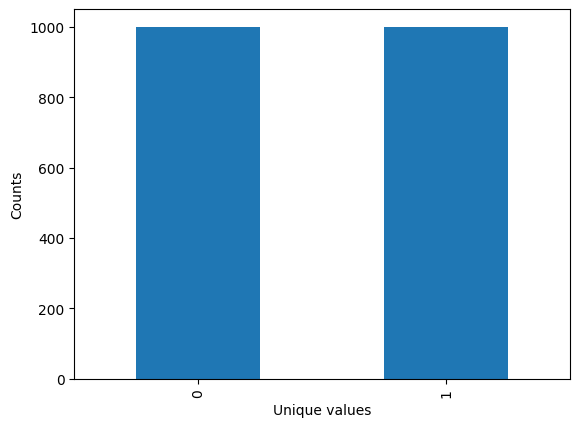

In [78]:
plot = pd.value_counts(y_train).plot(kind = "bar")
plt.xlabel("Unique values")
plt.ylabel("Counts")
plt.show()

### Imbalanced Data with smote
* we reduce the rows so no need to smote and its seems that they are the same
* Note : `Imblearn` not work with newer sklearn version
* `scikeras` not work with old versions

so we will not use smote here and if we selected 1000 first sample its already imbalnced

In [79]:
# resize images for smote
x_train = x_train.reshape(-1,150*150*1)

In [80]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=2)
# X_smote, y_smote = sm.fit_resample(x_train, y_train)

In [81]:
X_smote = x_train.reshape(-1, img_size, img_size, 1)
y_smote = y_train

In [82]:
from tensorflow import keras
class MCDropout(keras.layers.Dropout):
    def call(self , inputs):
        return super().call(inputs , training = True )

In [83]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D , MaxPool2D , Flatten
from tensorflow.keras import regularizers , constraints


In [84]:

def SimpleModel(units=32, dropout_rate=0.5):
    simpleModel = Sequential()
    simpleModel.add(Conv2D(units , kernel_size = (3,3),  strides = 1  , padding = 'same' , activation = 'linear' , input_shape = (150,150,1)))
    simpleModel.add(MaxPool2D((2,2)))


    simpleModel.add(Conv2D(units , (3,3), activation = 'relu' , kernel_regularizer = regularizers.l2(l2 = 0.01)))
    simpleModel.add(MaxPool2D(pool_size = (2,2)))
    simpleModel.add(MCDropout(dropout_rate))


    simpleModel.add(Flatten())
    simpleModel.add(Dense(units = 256 , activation = 'relu' , kernel_initializer = "glorot_uniform" , kernel_regularizer = regularizers.l2(l2 = 0.01)))
    simpleModel.add(MCDropout(dropout_rate))

    simpleModel.add(Dense(1 ,  activation = 'sigmoid' , kernel_initializer = "glorot_uniform" ))
    simpleModel.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

    return simpleModel

In [85]:
from tensorflow.keras import optimizers , losses
from tensorflow.keras.callbacks import EarlyStopping
simpleModel = SimpleModel()
early_stopping = EarlyStopping()

simpleModel.compile(
    loss = "binary_crossentropy",
    optimizer = optimizers.Adam(learning_rate = 0.0001),
    metrics =['accuracy']
)
history = simpleModel.fit(X_smote, y_smote , epochs = 10 , batch_size = 32, validation_data = (x_val , y_val), shuffle=True )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 25s 219ms/step - accuracy: 0.6488 - loss: 4.9595 - val_accuracy: 0.6875 - val_loss: 2.7660
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.8563 - loss: 2.2256 - val_accuracy: 0.6875 - val_loss: 1.9073
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9058 - loss: 1.4552 - val_accuracy: 0.5625 - val_loss: 1.5852
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9204 - loss: 1.1711 - val_accuracy: 0.8125 - val_loss: 1.2941
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9276 - loss: 1.0179 - val_accuracy: 0.8125 - val_loss: 1.1872
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9277 - loss: 0.9275 - val_accuracy: 0.8750 - val_loss: 1.0548
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9289 - loss: 0.8612 - val_accuracy: 0.8750 - val_loss: 1.0215
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.9312 - loss: 0.7962 - val_accuracy: 0.8750 -

### evaluate the model

In [86]:
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [87]:
y_pred = simpleModel.predict(x_test)
cr = classification_report(y_test,np.round(y_pred))
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 249ms/step
              precision    recall  f1-score   support

           0       0.87      0.58      0.70       234
           1       0.79      0.95      0.86       390

    accuracy                           0.81       624
   macro avg       0.83      0.76      0.78       624
weighted avg       0.82      0.81      0.80       624



In [88]:
accuracy_score(y_test , np.round(y_pred)) * 100

81.08974358974359

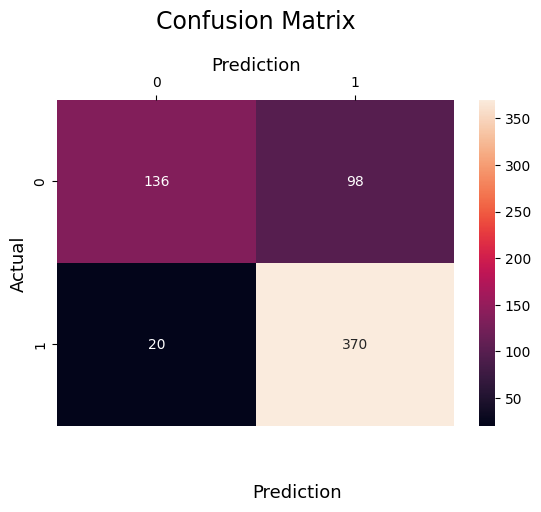

In [89]:
cm = confusion_matrix(y_test,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


* we used less train data its about 2k rows and we got a nice accuracy

### using diffrent model

In [90]:
from keras.layers import BatchNormalization , Dropout
from keras.callbacks import ReduceLROnPlateau

def SecondModel():
    model = Sequential()
    model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'linear' , input_shape = (150,150,1)))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.1))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
    model.add(Dropout(0.2))
    # model.add(BatchNormalization())
    model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

    model.add(Flatten())
    model.add(Dense(units = 128 , activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1 , activation = 'sigmoid'))
    model.compile(optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
    model.summary()

    return model


* if u uncomments the Batchnormalization layers u will got 0.5 on val accuracy maybe cause u use high batch size

In [91]:
secondModel = SecondModel()

Model: "sequential_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_56 (Conv2D)                   │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_55 (MaxPooling2D)      │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_57 (Conv2D)                   │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_56 (MaxPooling2D)      │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_58 (Conv2D)                   │ (None, 38, 38, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_57 (MaxPooling2D)      │ (None, 19, 19, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_59 (Conv2D)                   │ (None, 19, 19, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_58 (MaxPooling2D)      │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_60 (Conv2D)                   │ (None, 10, 10, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_59 (MaxPooling2D)      │ (None, 5, 5, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_26 (Flatten)                 │ (None, 6400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_52 (Dense)                     │ (None, 128)                 │         819,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_53 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,244,225 (4.75 MB)

 Trainable params: 1,244,225 (4.75 MB)

 Non-trainable params: 0 (0.00 B)

In [92]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)


In [93]:

history = secondModel.fit(X_smote,y_smote, batch_size = 32 ,epochs = 5 , validation_data = (x_val, y_val) ,callbacks = [learning_rate_reduction])


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 23s 186ms/step - accuracy: 0.5392 - loss: 0.6825 - val_accuracy: 0.5625 - val_loss: 0.7319 - learning_rate: 0.0010
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9071 - loss: 0.2506 - val_accuracy: 0.6250 - val_loss: 0.7833 - learning_rate: 0.0010
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.9181 - loss: 0.2021 - val_accuracy: 0.6250 - val_loss: 0.6881 - learning_rate: 0.0010
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.9616 - loss: 0.1204 - val_accuracy: 0.9375 - val_loss: 0.2661 - learning_rate: 0.0010
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - accuracy: 0.9721 - loss: 0.0943 - val_accuracy: 0.9375 - val_loss: 0.2051 - learning_rate: 0.0010


### evaluate the model

In [94]:
y_pred = secondModel.predict(x_test)
cr = classification_report(y_test,np.round(y_pred))
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
              precision    recall  f1-score   support

           0       0.90      0.52      0.66       234
           1       0.77      0.96      0.86       390

    accuracy                           0.80       624
   macro avg       0.83      0.74      0.76       624
weighted avg       0.82      0.80      0.78       624



In [95]:
accuracy_score(y_test , np.round(y_pred)) * 100

79.8076923076923

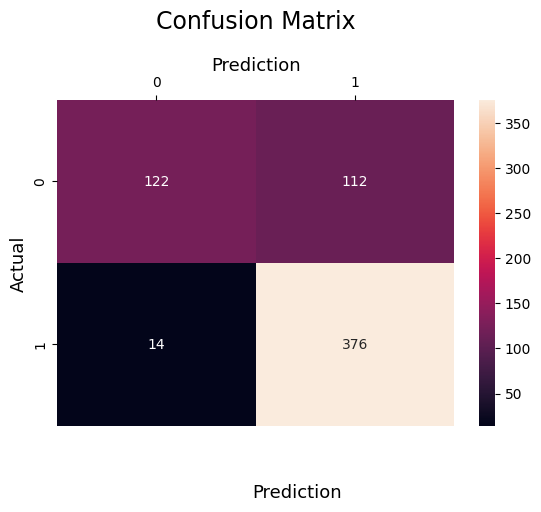

In [96]:
cm = confusion_matrix(y_test,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()


In [97]:
!pip install scikeras

### using Randmoized Search CV

In [98]:
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [121]:
# it take a long time so maybe we will try it later
param_grid = {
    'units': [32, 64],
    'dropout_rate': [0.6, 0.5],
}


model = KerasClassifier(build_fn=SimpleModel,
                            units=32,
                            dropout_rate=0.5,
                            epochs=5,
                            batch_size=32,
                            verbose=0)


RS = RandomizedSearchCV(estimator= model,
                                       param_distributions=param_grid,
                                       cv=3)

best_parameters = RS.fit(X_smote, y_smote )

In [122]:
bestDataFrame = pd.DataFrame(best_parameters.cv_results_)[["params"]]

In [123]:
bestDataFrame.params[0]

{'units': 32, 'dropout_rate': 0.5}

In [124]:
# take the best paramters
best = best_parameters.best_params_

In [125]:
bestModel = SimpleModel(bestDataFrame.params[0]["units"] , bestDataFrame.params[0]["dropout_rate"])
history = simpleModel.fit(X_smote, y_smote , epochs = 10 , batch_size = 32, validation_data = (x_val , y_val), shuffle=True )

Epoch 1/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9534 - loss: 0.3814 - val_accuracy: 0.8750 - val_loss: 0.4948
Epoch 2/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9416 - loss: 0.4062 - val_accuracy: 0.8750 - val_loss: 0.7417
Epoch 3/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.9387 - loss: 0.4158 - val_accuracy: 0.9375 - val_loss: 0.5727
Epoch 4/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9472 - loss: 0.3982 - val_accuracy: 0.7500 - val_loss: 0.7815
Epoch 5/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9449 - loss: 0.4134 - val_accuracy: 0.8125 - val_loss: 0.6114
Epoch 6/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9442 - loss: 0.3812 - val_accuracy: 0.8125 - val_loss: 0.5233
Epoch 7/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.9438 - loss: 0.3898 - val_accuracy: 0.9375 - val_loss: 0.5683
Epoch 8/10
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9556 - loss: 0.3685 - val_accuracy: 0.9375 - v

In [126]:
y_pred = bestModel.predict(x_test)
cr = classification_report(y_test,np.round(y_pred))
print(cr)

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 187ms/step
              precision    recall  f1-score   support

           0       0.38      0.62      0.47       234
           1       0.63      0.38      0.47       390

    accuracy                           0.47       624
   macro avg       0.50      0.50      0.47       624
weighted avg       0.53      0.47      0.47       624



In [127]:
accuracy_score(y_test , np.round(y_pred)) * 100

47.11538461538461

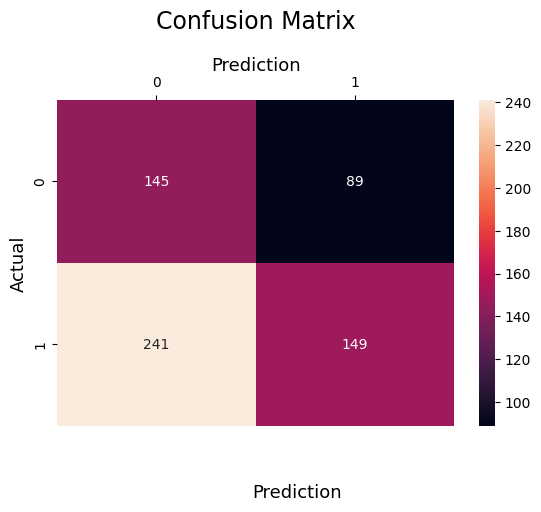

In [128]:
cm = confusion_matrix(y_test,np.round(y_pred))

sns.heatmap(cm, annot=True, fmt='g', xticklabels=['0','1'], yticklabels=['0','1'])
plt.ylabel('Actual', fontsize=13)
plt.title('Confusion Matrix', fontsize=17, pad=20)
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Prediction', fontsize=13)
plt.gca().xaxis.tick_top()
plt.gca().figure.subplots_adjust(bottom=0.2)
plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
plt.show()
